In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#Essentials
import numpy as np
import pandas as pd
import pickle
import re
from sklearn.pipeline import Pipeline

#Plotting fun
import matplotlib.pyplot as plt
import seaborn as sns

#NLP fun
import nltk
from  collections  import namedtuple

#Text cleaning (stemming, lemmatizing, etc.)
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import inflection
from autocorrect import spell

#Vectorizing
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 

# Dimentionality reduction
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation, PCA

#NLP clustering
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, DBSCAN

#Clustering help
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

#Clustering visualization
from sklearn.manifold import TSNE

#Fun stuff
import pyLDAvis
import pyLDAvis.sklearn

#Nice to have
# from collections import Counter
#from gensim import corpora, models, similarities, matutils, Word2vec, emoji2vec
# from nltk.tokenize import TreebankWordTokenizer
# from nltk.tokenize import wordpunct_tokenize
# from nltk.chunk import ne_chunk
# from nltk.corpus import treebank_chunk
# from operator import itemgetter


#Neural nets
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# import torch.nn.functional as F
# from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline

### Helper functions

In [3]:
def simple_pos(pos):
    if pos == 'NOUN':
        return 'n'
    elif pos == 'VERB':
        return 'v'
    elif pos == 'ADJ':
        return 'a'
    elif pos == 'ADV':
        return 'r'
    elif pos == 'ADJ_SAT':
        return 's'
    else:
        return 'n'


def process_words(string):
    """Takes a string as input.
    Returns the string after lemmatizing and singularizing the words."""
    processed_string = string
    lmtzr = WordNetLemmatizer()
    word_pos_pair = pos_tag(word_tokenize(processed_string), tagset='universal')
    for word, pos in word_pos_pair:
        word_pos = simple_pos(pos)
        #spell_correct = ' '+spell(word) if "'" in word else spell(word)
        lame_word = lmtzr.lemmatize(word, word_pos)
        singular_word = inflection.singularize(lame_word)
        processed_string = processed_string.replace(word, singular_word)
    return processed_string 
    
    
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def get_issue_name(issue_index):
    """Takes the cluster index.
    Returns the issue name."""
    cluster_name_list = ['Issue with Contacting Customer Service', 'Poor Customer Service', 'Missed Connection', 'Cancellation due to weather',
                       'Poor Customer Service', 'Boarding / Deplaning Issue', 'Rebooking Issues', 'Lost Baggage', 'Bad Weather Related', 
                       'Poor Service from Airport Agent(s)']
    cluster_index = int(issue_index)
    issue = cluster_name_list[cluster_index]
    return issue
    

In [4]:
#Moving forward read from pickle rather than repeat above steps
with open('negative_tweets.pkl', 'rb') as picklefile:
    negative_tweets = pickle.load(picklefile)

In [5]:
negative_tweets = negative_tweets.drop(columns=['tweet', 'retweet_count', 'sentiment'])
negative_tweets.head()

,airline,tweet_clean
1,Delta,is REALLY getting on my nerves !!
2,United,yes. We waited in line for almost an hour to ...
3,United,the we got into the gate at on time and have...
6,United,I like delays less than you because I'm the o...
7,United,", link to current status of flights/airports? ..."


## Now, it's time to vectorize the tweets

In [6]:
#Some prep work (lemmatize)
tweet_col = negative_tweets['tweet_clean']
tweet_col = [process_words(tweet) for tweet in tweet_col]


In [7]:
tweet_col[:10]

[' be REALLY get on my nerve !!  ',
 ' ye. We wait in line for almost an hour to do so. Some passenger just leave not want to wait past be.',
 ' the we get into the gate at  on time and have give our seat and close the flight. If you know person be arrive, have to wait',
 " I like delay less than you because I'm the one on the plane. Connect me with a voucher",
 ", link to current status of flights/airport? Fly BWI-EWR-MCO thi morning yet can't yet tell what any problem be except see snow.",
 ' I try  DM it would not go thru... not sure why',
 " i have item of sentimental value that I'm heartbroken be miss",
 ' We have be stick in  for several hour and no one be answer here. Really tough to  SW. No response be bad.',
 ' be officially the bad, most delay, and least helpful airline I have ever have the mbefortune of fly on',
 " won't answer their phone    "]

In [8]:
#Some prep work (removing some of the most popular, but not indicative words)
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', '!', ':', 'DM', 'dm', 'Dm', 'get', 'amp', 'yes', 'no', 'thi', 'ua', 'go', 'airline', 'every',
         'flight', 'flighting', 'fly', 'flightled', 'flighted', 'flightr', 'flightlation', 'ever', 'never',
         'minute', 'min', 'hour', 'hr', 'day', 'today', 'tonight', 'tomorrow', 'time', 'first', 'last',]
stop = set(stop)

#### Count Vectorizer method

In [9]:
params = {
            'strip_accents': 'ascii',
            'lowercase': True,
            'stop_words': stop, 
            'min_df': 5,
            'ngram_range': (1, 2)
         }

In [10]:
#Count vectorizer case
count_vec = CountVectorizer(**params)
negative_tweets_cv_viz = count_vec.fit_transform(tweet_col)
negative_tweets_cv = negative_tweets_cv_viz.toarray()
negative_tweets_cv = pd.DataFrame(negative_tweets_cv, columns=count_vec.get_feature_names())
negative_tweets_cv.head()

,00,aa,able,absolute,absolutely,absurd,accept,acceptable,access,accommodate,...,year old,yell,yep,yesterday,yet,yo,youre,yr,yr old,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


#### TF-IDF method

In [11]:
#TF-IDF 
tfidf_vec = TfidfVectorizer(**params)
negative_tweets_tfidf_viz = tfidf_vec.fit_transform(tweet_col)
negative_tweets_tfidf = negative_tweets_tfidf_viz.toarray()
negative_tweets_tfidf = pd.DataFrame(negative_tweets_tfidf, columns=tfidf_vec.get_feature_names())
negative_tweets_tfidf.head()

,00,aa,able,absolute,absolutely,absurd,accept,acceptable,access,accommodate,...,year old,yell,yep,yesterday,yet,yo,youre,yr,yr old,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.459752,0.0,0.0,0.0,0.0,0.0


In [12]:
#Explore the matrix to see which words show up the most and evaluate
# total_words = negative_tweets_cv.shape
# total_words = total_words[0]
# word_summary = negative_tweets_cv.sum().sort_values(ascending=False)
# word_frequency = pd.DataFrame(word_summary, columns=['freq'])
# word_frequency['freq_prop'] = [freq / total_words for freq in word_frequency['freq']]
# word_frequency.head(50)

## Dimensionality reduction fun

In [13]:
#Number of topics
n_topics = 9
n_words = 7
n_iter = 5

#### Different dimensionality reduction techniques applied CountVectorized data

#### Counter Vectorizer + LSA

In [14]:
#CountVectorizer + LSA
# lsa_cv_model = TruncatedSVD(n_components=n_topics)
# lsa_cv_data = lsa_cv_model.fit_transform(negative_tweets_cv)

In [15]:
# print('Count vectorizer and LSA:')
# display_topics(lsa_cv_model, count_vec.get_feature_names(), n_words)

In [16]:
# lsa_cv_tsne = TSNE(n_components = 2, perplexity = 50.0)
# lsa_cv_sne = lsa_cv_tsne.fit_transform(lsa_cv_data)

In [17]:
# plt.figure(dpi=100)  
 
# plt.scatter(lsa_cv_sne[:, 0], lsa_cv_sne[:, 1], alpha=0.5)
# plt.title('tSNE on LSA CV model');

#### Counter Vectorizer + NMF

In [18]:
#CountVectorizer + NMF
nmf_cv_model = NMF(n_components=n_topics)
nmf_cv_data = nmf_cv_model.fit_transform(negative_tweets_cv)

In [19]:
print('Count vectorizer and NMF:')
display_topics(nmf_cv_model, count_vec.get_feature_names(), n_words)

Count vectorizer and NMF:

Topic  0
service, customer, customer service, terrible, worst, poor, worst customer

Topic  1
cancelled, hold, one, rebook, weather, due, refund

Topic  2
delay, due, miss, connection, delay due, crew, weather

Topic  3
bag, lose, check, still, lose bag, baggage, late

Topic  4
plane, sit, late, leave, one, sit plane, gate

Topic  5
call, back, late, call back, tell, hold, try

Topic  6
bad, weather, experience, make, bad weather, bad experience, thank

Topic  7
problem, booking, booking problem, help, seat, need, reflight booking

Topic  8
wait, gate, agent, still, gate agent, phone, hold


In [20]:
topic_list = ['Poor Customer Service', 'Cancellation due to weather', 'Missed Connection', 'Lost Baggage', 'Boarding / Deplaning Issue',
                   'Issue with Contacting Customer Service', 'Bad Weather Related', 'Rebooking Issues', 'Poor Service from Airport Agent(s)']


In [21]:
nmf_cv_tsne = TSNE(n_components = 2, perplexity = 50.0)
nmf_cv_sne = nmf_cv_tsne.fit_transform(nmf_cv_data)

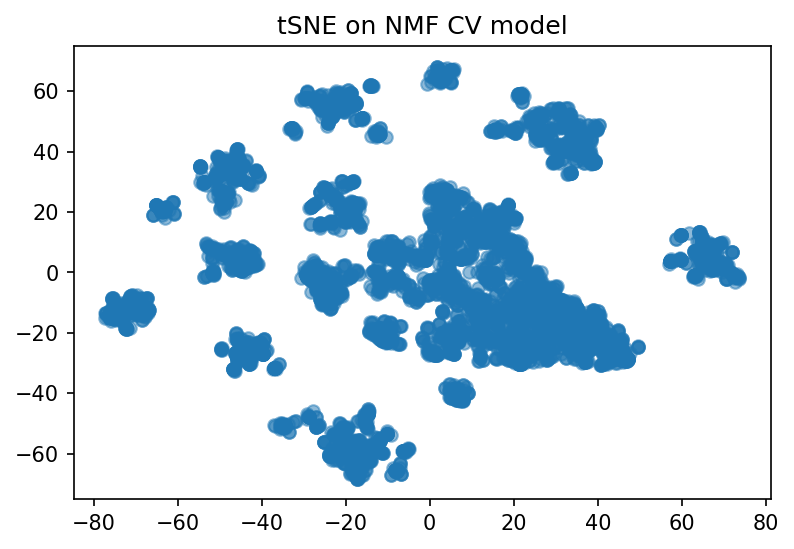

In [22]:
plt.figure(dpi=150)  
 
plt.scatter(nmf_cv_sne[:, 0], nmf_cv_sne[:, 1], alpha=0.5)
plt.title('tSNE on NMF CV model');

In [23]:
#Let's see what topic would lda reduce this new tweet to
nmf_cv_model.transform(count_vec.transform(['I got hold up at the gate']))

array([[0.        , 0.02368561, 0.        , 0.        , 0.00851868,
        0.02542048, 0.        , 0.        , 0.10668586]])

#### Count Vectorizer + LDA

In [24]:
#CountVectorizer + LDA
# lda_cv_model = LatentDirichletAllocation(n_components=n_topics,
#                                     max_iter=n_iter,
#                                     random_state=42,
#                                     learning_method='online')

# lda_cv_data = lda_cv_model.fit_transform(negative_tweets_cv);

In [25]:
#Let's see what topic would lda reduce this new tweet to
# lda_cv_model.transform(count_vec.transform(['this flight sucked, it was 2 hours delayed']))

In [26]:
# print('Count vectorizer and LDA:')
# display_topics(lda_cv_model, count_vec.get_feature_names(), n_words)

In [27]:
# lda_cv_tsne = TSNE(n_components = 2, perplexity = 50.0)
# lda_cv_sne = lda_cv_tsne.fit_transform(lda_cv_data)

In [28]:
# plt.figure(dpi=100)  
 
# plt.scatter(lda_cv_sne[:, 0], lda_cv_sne[:, 1], alpha=0.5)
# plt.title('tSNE on LDA CV model');

#### CountVectorizer + PCA

In [29]:
#CountVectorizer + PCA
# pca_cv_model = PCA(n_components=n_topics, random_state=42)
# pca_cv_data = pca_cv_model.fit_transform(negative_tweets_cv);

In [30]:
# # print('Count vectorizer and PCA:')
# display_topics(pca_cv_model, count_vec.get_feature_names(), n_words)

In [31]:
# pca_cv_tsne = TSNE(n_components = 2, perplexity = 50.0)
# pca_cv_sne = lsa_cv_tsne.fit_transform(lsa_cv_data)

In [32]:
# plt.figure(dpi=100)  
 
# plt.scatter(pca_cv_sne[:, 0], pca_cv_sne[:, 1], alpha=0.5)
# plt.title('tSNE on PCA CV model');

#### Different dimensionality reduction techniques applied TF-IDFed data

#### TF-IDF + LSA

In [33]:
# #LSA + TF-IDF
# lsa_tfidf_model = TruncatedSVD(n_components=n_topics)
# lsa_tfidf_data = lsa_tfidf_model.fit_transform(negative_tweets_tfidf)

In [34]:
# print('TF-IDF and LSA:')
# display_topics(lsa_tfidf_model, tfidf_vec.get_feature_names(), n_words)

In [35]:
# lsa_tfidf_tsne = TSNE(n_components = 2, perplexity = 50.0)
# lsa_tfidf_sne = lsa_tfidf_tsne.fit_transform(lsa_tfidf_data)

In [36]:
# plt.figure(dpi=100)  
 
# plt.scatter(lsa_tfidf_sne[:, 0], lsa_tfidf_sne[:, 1], alpha=0.5)
# plt.title('tSNE on LSA TF-IDF model');

#### TF-IDF + PCA

In [37]:
#TF-IDF + PCA
# pca_tfidf_model = PCA(n_components=n_topics, random_state=42)
# pca_tfidf_data = pca_tfidf_model.fit_transform(negative_tweets_cv);

In [38]:
# # print('TF-IDF and PCA:')
# display_topics(pca_tfidf_model, tfidf_vec.get_feature_names(), n_words)

In [39]:
# pca_tfidf_tsne = TSNE(n_components = 2, perplexity = 50.0)
# pca_tfidf_sne = pca_tfidf_tsne.fit_transform(pca_tfidf_data)

In [40]:
# plt.figure(dpi=100)  
 
# plt.scatter(pca_tfidf_sne[:, 0], pca_tfidf_sne[:, 1], alpha=0.5)
# plt.title('tSNE on PCA TF-IDF model');

#### TF-IDF + LDA

In [41]:
#LDA + TF-IDF
# lda_tfidf_model = LatentDirichletAllocation(n_components=n_topics,
#                                     max_iter=n_iter,
#                                     random_state=42,
#                                     learning_method='online')

# lda_tfidf_data = lda_tfidf_model.fit_transform(negative_tweets_tfidf)

In [42]:
# print('TF-IDF and LDA:')
# display_topics(lda_tfidf_model, tfidf_vec.get_feature_names(), n_words)

In [43]:
# lda_tfidf_tsne = TSNE(n_components = 2, perplexity = 50.0)
# lda_tfidf_sne = lda_tfidf_tsne.fit_transform(lda_tfidf_data)

In [44]:
#Let's see what topic would lda reduce this new tweet to
# lda_tfidf_model.transform(tfidf_vec.transform(['this flight sucked, it was 2 hours delayed']))

In [45]:
# plt.figure(dpi=150)  
 
# plt.scatter(lda_tfidf_sne[:, 0], lda_tfidf_sne[:, 1], alpha=0.5)
# plt.title('tSNE on LDA TF-IDF model');

### Maybe visualizing LDAs will help

In [46]:
#Prep for viz
# LDA_CV = [lda_cv_model, negative_tweets_cv_viz, count_vec]
# LDA_TFIDF = [lda_tfidf_model, negative_tweets_tfidf_viz, tfidf_vec]

In [47]:
# pyLDAvis.enable_notebook()
# pyLDAvis.sklearn.prepare(*LDA_CV) #options for scaling mds='tsne' or mds='mmds'

In [48]:
# pyLDAvis.sklearn.prepare(*LDA_TFIDF, mds='tsne') #options for scaling mds='tsne' or mds='mmds'

### Let's save the model and the dimensionally reduced dataset

In [49]:
# with open('count_vec.pkl', 'wb') as picklefile_cv:
#     pickle.dump(count_vec, picklefile_cv)

# with open('nmf_dim_reduction.pkl', 'wb') as picklefile_nmf:
#     pickle.dump(nmf_cv_model, picklefile_nmf)

# with open('vectorized_dataset.pkl', 'wb') as picklefile_d:
#     pickle.dump(nmf_cv_data, picklefile_d)

In [50]:
with open('count_vec.pkl', 'rb') as picklefile_cv:
    count_vec = pickle.load(picklefile_cv)

with open('nmf_dim_reduction.pkl', 'rb') as picklefile_nmf:
    nmf_dim_reduction = pickle.load(picklefile_nmf)

with open('vectorized_dataset.pkl', 'rb') as picklefile_d:
    vectorized_dataset = pickle.load(picklefile_d)

In [51]:
# vectorized_dataset[1]

## Clustering Time!

In [52]:
#Let's start with KMeans
inertia = [0,0]

for n_clusters in range(2, 20):
    km = KMeans(n_clusters = n_clusters)
    km.fit(vectorized_dataset)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 159.351632
# clusters:  3   Inertia: 144.465832
# clusters:  4   Inertia: 125.109878
# clusters:  5   Inertia: 105.235717
# clusters:  6   Inertia: 90.450283
# clusters:  7   Inertia: 78.242051
# clusters:  8   Inertia: 65.899422
# clusters:  9   Inertia: 56.759794
# clusters: 10   Inertia: 48.027480
# clusters: 11   Inertia: 45.463125
# clusters: 12   Inertia: 43.185886
# clusters: 13   Inertia: 40.856719
# clusters: 14   Inertia: 39.325273
# clusters: 15   Inertia: 38.922143
# clusters: 16   Inertia: 37.502310
# clusters: 17   Inertia: 35.977986
# clusters: 18   Inertia: 34.686517
# clusters: 19   Inertia: 33.638585


Text(0,0.5,'Inertia')

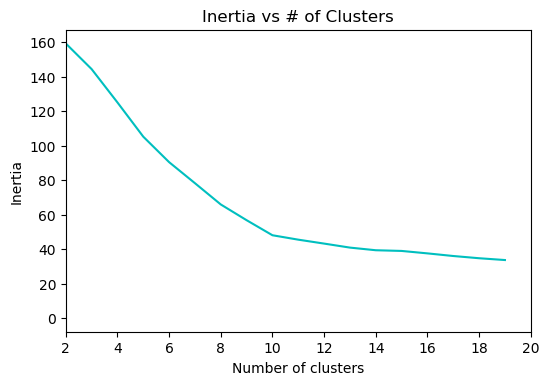

In [53]:
plt.figure(dpi=100)
plt.plot(inertia, color='c')
plt.title('Inertia vs # of Clusters')
plt.xlim(2, 20)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

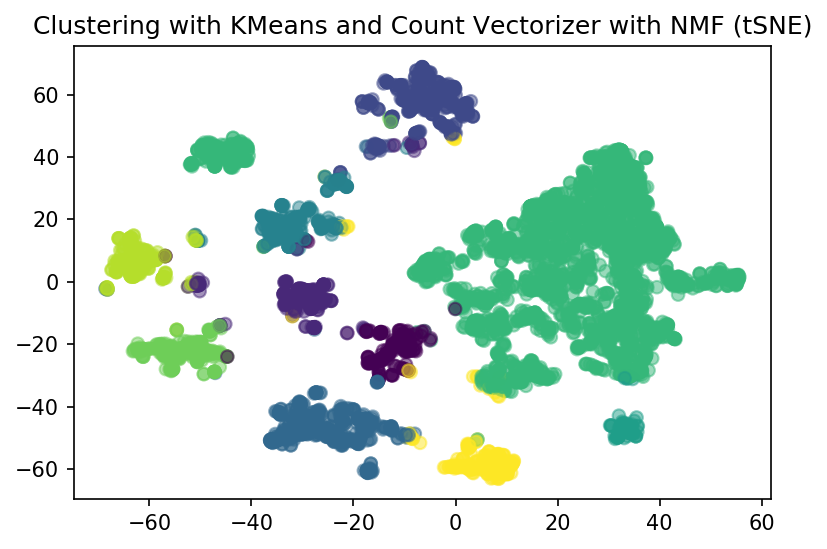

In [54]:
n_clusters = 10

km_classifier = KMeans(n_clusters = n_clusters, random_state=42)
km_classifier.fit(vectorized_dataset)


final_tsne = TSNE(n_components = 2, perplexity = 50.0)
final_sne = final_tsne.fit_transform(vectorized_dataset)

plt.figure(dpi=150)
plt.scatter(final_sne[:, 0], final_sne[:, 1], c=km_classifier.labels_, alpha=0.5)
plt.title('Clustering with KMeans and Count Vectorizer with NMF (tSNE)');

In [55]:
# for i in range(9):
#     print(i, vectorized_dataset[:,i])

In [56]:
topic_list = ['Poor Customer Service', 'Cancellation due to weather', 'Missed Connection', 'Lost Baggage', 'Boarding / Deplaning Issue',
                   'Issue with Contacting Customer Service', 'Bad Weather Related', 'Rebooking Issues', 'Poor Service from Airport Agent(s)']


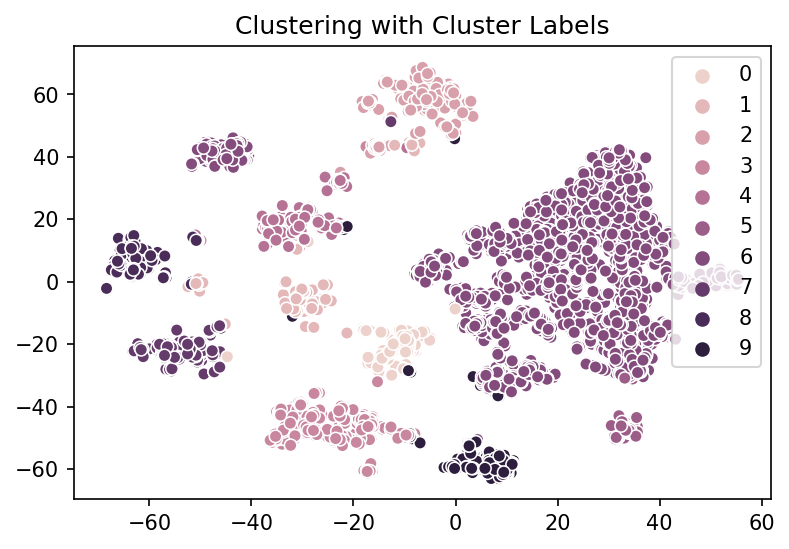

In [57]:
plt.figure(dpi=150)
plt.title('Clustering with Cluster Labels')
sns.scatterplot(final_sne[:, 0], final_sne[:, 1], hue = km_classifier.labels_, legend ='full');

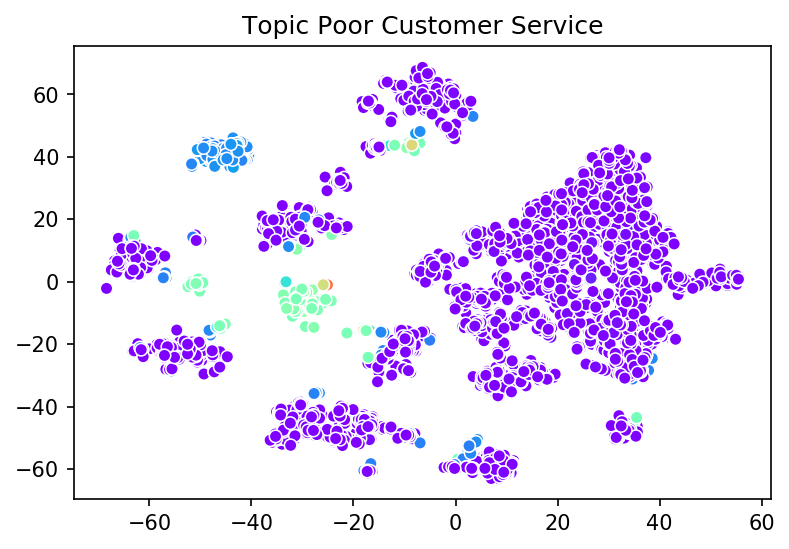

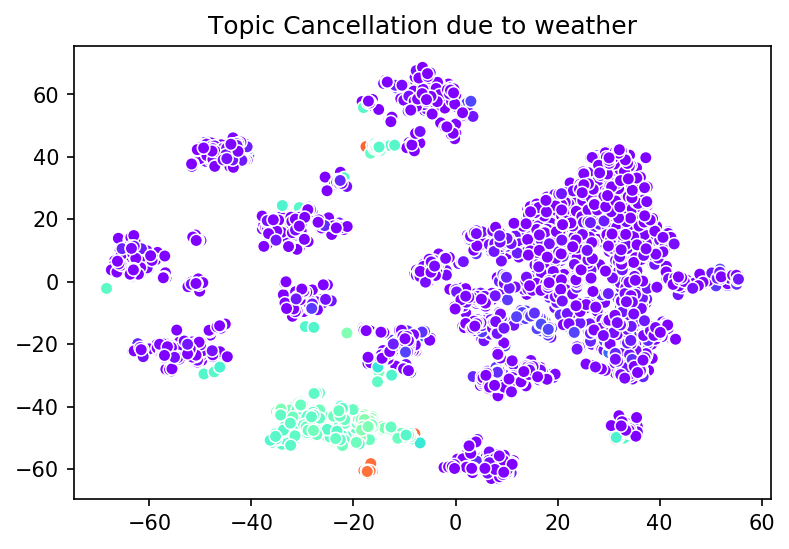

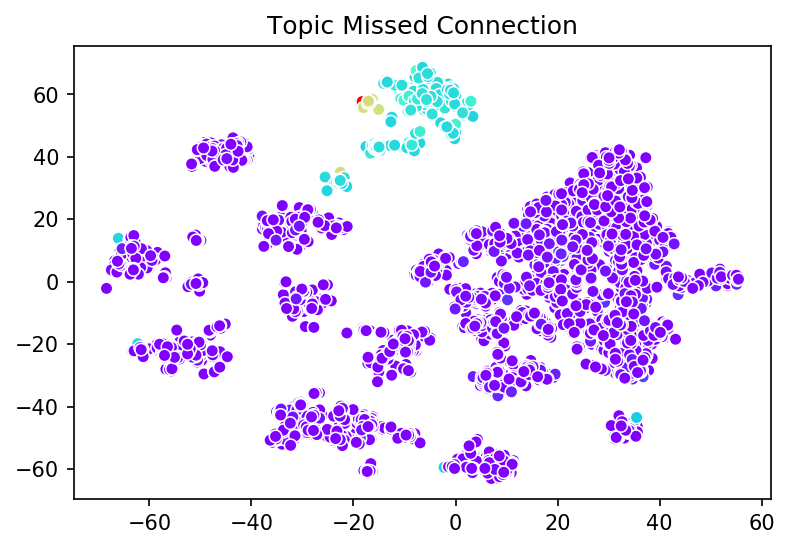

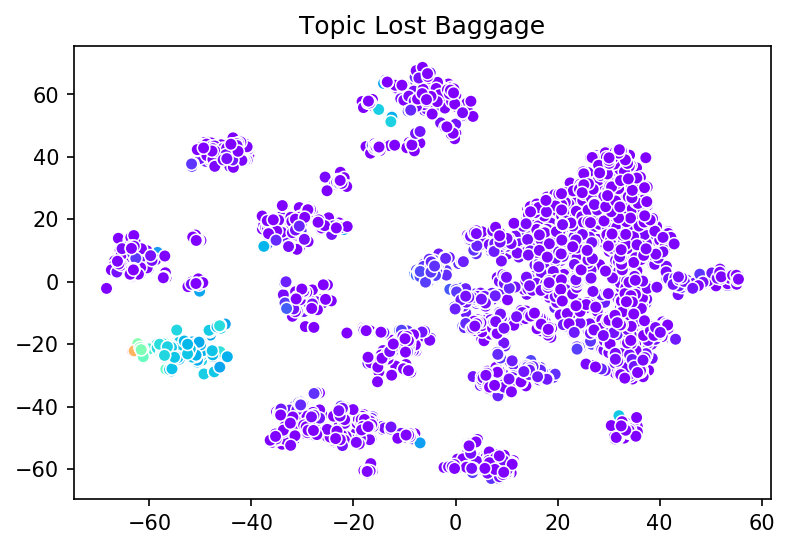

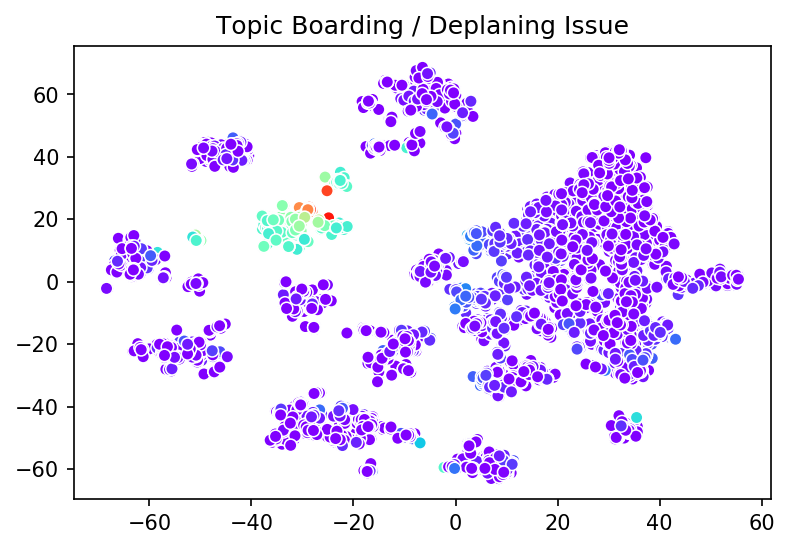

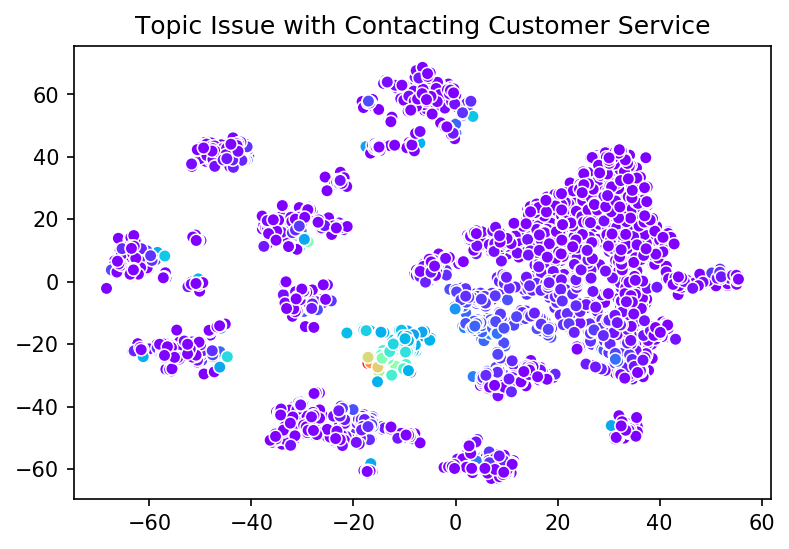

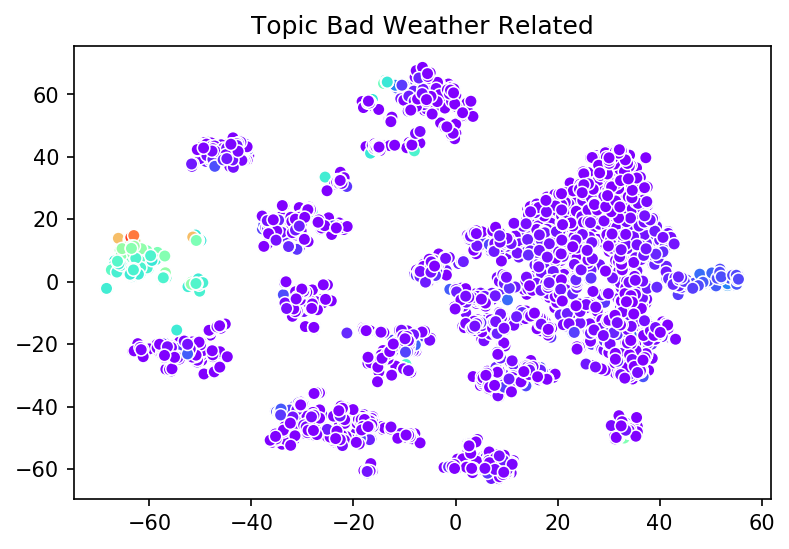

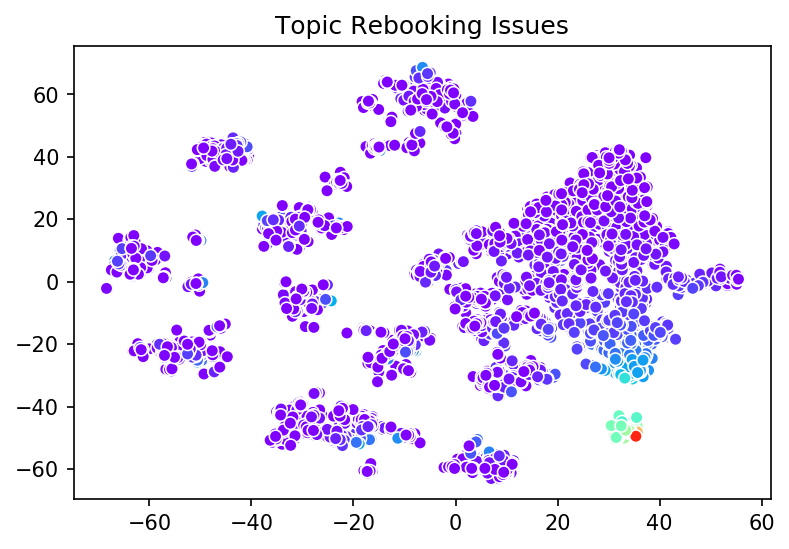

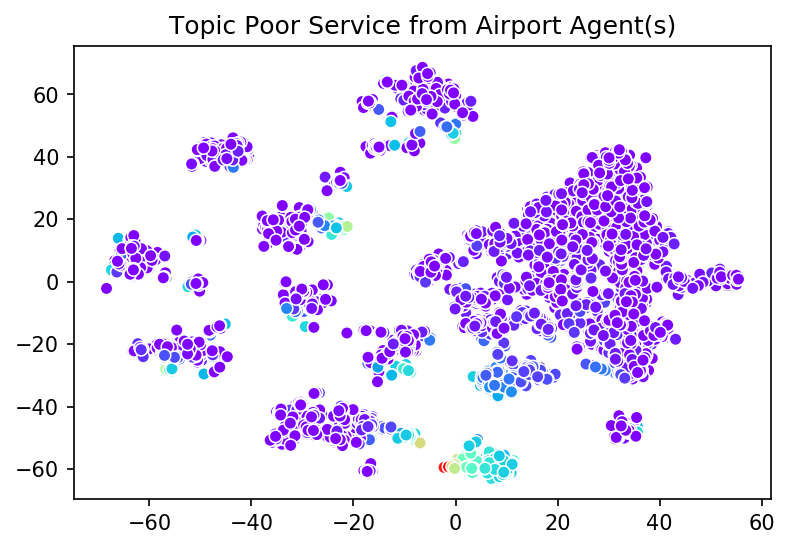

In [58]:
for i in range(9):
    plt.figure(dpi=150)
    sns.scatterplot(final_sne[:, 0], final_sne[:, 1], hue=vectorized_dataset[:,i], legend=None, palette='rainbow')
    plt.title('Topic ' + str(topic_list[i]));

In [82]:
issue_index = km_classifier.predict(nmf_dim_reduction.transform(count_vec.transform(["What a rude customer service on the phone"])))
print(issue_index)
get_issue_name(issue_index)

[1]


'Poor Customer Service'

### Save the final model

In [60]:
# with open('km_classifier.pkl', 'wb') as picklefile_c:
#     pickle.dump(km_classifier, picklefile_c)

### Helper function for classification

In [70]:
def classify_issue(string):
    """Takes a string (tweet).
    Returns an issue class it belongs to (based on the pretrained model)."""
    with open('km_classifier.pkl', 'rb') as model:
        km_classifier = pickle.load(model)
#     processed_tweet = process_words(get_clean_tweet(string))
#     vectorized_tweet = count_vec.transform([processed_tweet])
#     ready_tweet = nmf_dim_reduction.transform(vectorized_tweet)
    issue = km_classifier.predict(string)
    return issue

## Et Voila! Let's recommend some actions!

In [71]:
def make_suggestion(string):
    """Takes a string, puts it through a pipeline of actions:
            1. Defines the sentiment (if NOT negative, returns 'You have a happy customer')
            2. Cleans the string (removes codes, hashtags, emojis, airlines, etc.)
            3. Processes words (lemmatization, singularization, etc.)
            4. Classifies into one of ... topics"""
    #Defining an action for each issue
    action_dict = {'Poor Customer Service': 'Please Improve Customer Service Rep Training \U0001F61E',
                  'Cancellation Due To Weather': "Weather Is Out of Your Control, Relax \U0001F4A8",
                   'Missed Connection': "Please Improve Your Scheduling \U0001F553",
                   'Lost Baggage': "Please Pay More Attention at Baggage Handling \U0001F45C",
                   'Boarding / Deplaning Issue': 'Please Work on Your Boarding Process \u2708',
                   'Issue with Contacting Customer Service': "Please Improve Customer Service Accessibility \u260E",
                   'Bad Weather Related': "Weather Is Out of Your Control, Relax \U0001F4A8",
                   'Rebooking Issues': "Please Improve Your Rebooking Process \U0001F3AB",
                   'Poor Service from Airport Agent(s)': 'Please Work On Training Your Airport / On Board Staff \u2708 \U0001F46B'}
    
    sentiment = get_sentiment(string)
    if sentiment != 'negative':
        return print('Keep up the good work! \U0001F44D')
    else:
        issue_index = classify_issue(string)
        issue = get_issue_name(issue_index)
        action = action_dict[issue]
    
    #Now finally choose the action
    return action
    

#### Testing fun

In [75]:
# with open('tweets_test.pkl', 'rb') as test_set:
#     tweets_test = pickle.load(test_set)

In [74]:
# random_test_tweet = tweets_test.iloc[np.random.choice(len(tweets_test))]['tweet']
# print('Test tweet is: "' + str(random_test_tweet) + '"')
# print('The model suggests you to: ' + str(make_suggestion(random_test_tweet)))